In [1]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def one_hot_encoding(y_array):
    from sklearn.preprocessing import LabelBinarizer
    enc = LabelBinarizer()
    return enc.fit_transform(y_array)

### Load data from csv and transform to DataLoader

In [53]:
def load_data_from_csv(file_name, y_column, batch_size=32, valid_size=0.25):
    import pandas as pd
    
    df = pd.read_csv(file_name).astype(float)
    df = df.sample(frac=1)  # shuffle dataframe
    train_size, valid_size = int(df.shape[0]*(1-valid_size)), int(df.shape[0]*(valid_size))
    print(f"train size = {train_size}, validation size = {valid_size}")
    
    y_train_np_data, y_valid_np_data = df[y_column].head(train_size).values, df[y_column].tail(valid_size).values
    x_train_np_data, x_valid_np_data = (df.drop(columns=[y_column]).head(train_size).values, 
                                        df.drop(columns=[y_column]).tail(valid_size).values)
    
    x_train_np_data, x_valid_np_data = x_train_np_data / 255., x_valid_np_data / 255.  # Normalize data
    x_train_np_data, x_valid_np_data = x_train_np_data.astype(np.float), x_valid_np_data.astype(np.float)
    
    # Encode data
    y_train_np_data, y_valid_np_data = (one_hot_encoding(y_train_np_data).astype(np.float), 
                                        one_hot_encoding(y_valid_np_data).astype(np.float))
    
    print(f"X train shape = {x_train_np_data.shape}, Y train shape = {y_train_np_data.shape}")
    
    y_train_tensor, y_valid_tensor = torch.from_numpy(y_train_np_data), torch.from_numpy(y_valid_np_data)
    x_train_tensor, x_valid_tensor = torch.from_numpy(x_train_np_data), torch.from_numpy(x_valid_np_data)
    
    tensor_ds_train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)  # create TRAIN tensor dataset
    tensor_ds_valid = torch.utils.data.TensorDataset(x_valid_tensor, y_valid_tensor)  # create VALID tensor dataset
    
    tensor_dl_train = torch.utils.data.DataLoader(tensor_ds_train, batch_size=batch_size, shuffle=True)
    tensor_dl_valid = torch.utils.data.DataLoader(tensor_ds_valid, batch_size=batch_size*2)
    
    return (tensor_dl_train, tensor_dl_valid)

In [54]:
train_dl, valid_dl = load_data_from_csv(file_name='mnist_dataset\\train.csv', y_column='label')

train size = 31500, validation size = 10500
X train shape = (31500, 784), Y train shape = (31500, 10)


### Define neural network

In [8]:
class ClassificationNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = nn.Softmax()
        
    def forward(self, x):
        h_out = self.hidden(x)
        y_out = self.output(h_out)
        
        return self.activation(y_out)

#### Define generator with loading to special device

In [9]:
def preprocess(x, y, input_size, device):
    return x.view(-1, input_size), y # .to(device)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        self.dev = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
    
    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for x_batch, y_batch in batches:
            yield (self.func(x_batch, y_batch, x_batch.shape[-1], self.dev))

### Define accuracy

In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    y_labels = torch.argmax(yb, dim=1)
    return torch.mean((preds == y_labels).float())

In [11]:
# warped_train = WrappedDataLoader(train_dl, preprocess)

In [82]:
# Init model
model = ClassificationNet(784, 10, 10).double()
model = model.to(torch.device(0))

# Init optimizer with model paraeters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
# Check model device
list(model.parameters())[0].get_device()

0

In [83]:
# Loss for binary classification
loss_func = F.binary_cross_entropy

### Define training function for model

training with gpu

In [84]:
def fit(model, epochs, optimizer, loss_func, train_dl, valid_dl=None):
    loss_history = []
    acc_history = []
    eval_loss_history = []
    
    for i in range(epochs):
        epoch_loss = []
        epoch_acc = []
        for xb, yb in train_dl:
            model.train()
            
            pred = model(xb.to(torch.device(0)))
            loss = loss_func(pred, yb.to(torch.device(0)))
            epoch_loss.append(loss.item())
            epoch_acc.append(accuracy(pred, yb.to(torch.device(0))).item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss_history.append(np.array(epoch_loss).mean())
        acc_history.append(np.array(epoch_acc).mean())
        eval_loss_str = ''
        
        if valid_dl is not None:
            model.eval()    
            with torch.no_grad():
                eval_loss_history.append(np.mean([loss_func(model(xb.cuda()), yb.cuda()).item() for xb, yb in valid_dl]))
            eval_loss_str = f'Eval loss: {eval_loss_history[-1]:.5}'
            
        print(f'Epoch {i+1}. Loss: {loss_history[-1]:.5}, Acc: {acc_history[-1]:.5}. ' + eval_loss_str)
        
    return (loss_history, acc_history, eval_loss_history)

In [85]:
loss_hist, acc_hist, eval_hist = fit(model, 30, optimizer, loss_func, train_dl, valid_dl)

<ipython-input-8-c0b960d54e2b>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(y_out)


Epoch 1. Loss: 0.23668, Acc: 0.59683. Eval loss: 0.16837
Epoch 2. Loss: 0.13493, Acc: 0.79249. Eval loss: 0.11303
Epoch 3. Loss: 0.09911, Acc: 0.84396. Eval loss: 0.090605
Epoch 4. Loss: 0.082815, Acc: 0.86704. Eval loss: 0.07882
Epoch 5. Loss: 0.073531, Acc: 0.87947. Eval loss: 0.071443
Epoch 6. Loss: 0.067479, Acc: 0.88862. Eval loss: 0.066553
Epoch 7. Loss: 0.063228, Acc: 0.89553. Eval loss: 0.06306
Epoch 8. Loss: 0.060139, Acc: 0.90078. Eval loss: 0.060439
Epoch 9. Loss: 0.057722, Acc: 0.90393. Eval loss: 0.058542
Epoch 10. Loss: 0.055877, Acc: 0.90731. Eval loss: 0.056779
Epoch 11. Loss: 0.054331, Acc: 0.9088. Eval loss: 0.055637
Epoch 12. Loss: 0.05314, Acc: 0.91126. Eval loss: 0.054499
Epoch 13. Loss: 0.051999, Acc: 0.91337. Eval loss: 0.05371
Epoch 14. Loss: 0.051085, Acc: 0.91437. Eval loss: 0.052828
Epoch 15. Loss: 0.050299, Acc: 0.91533. Eval loss: 0.052169
Epoch 16. Loss: 0.049544, Acc: 0.91721. Eval loss: 0.05159
Epoch 17. Loss: 0.048903, Acc: 0.91841. Eval loss: 0.0511
Ep

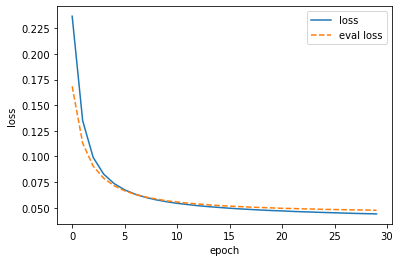

In [86]:
plt.plot(loss_hist, label='loss')
plt.plot(eval_hist, label='eval loss', linestyle='dashed')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

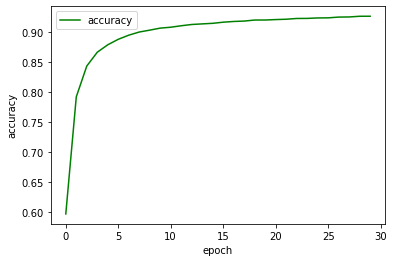

In [87]:
plt.plot(acc_hist, label='accuracy', color='g')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

### Use validation data for training

In [89]:
loss_hist, acc_hist, eval_hist = fit(model, 10, optimizer, loss_func, valid_dl)

<ipython-input-8-c0b960d54e2b>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(y_out)


Epoch 1. Loss: 0.04755, Acc: 0.92112. 
Epoch 2. Loss: 0.047204, Acc: 0.92178. 
Epoch 3. Loss: 0.046918, Acc: 0.92225. 
Epoch 4. Loss: 0.046649, Acc: 0.92311. 
Epoch 5. Loss: 0.046393, Acc: 0.92367. 
Epoch 6. Loss: 0.046146, Acc: 0.92462. 
Epoch 7. Loss: 0.045908, Acc: 0.92491. 
Epoch 8. Loss: 0.045678, Acc: 0.92538. 
Epoch 9. Loss: 0.045455, Acc: 0.92547. 
Epoch 10. Loss: 0.045239, Acc: 0.92585. 


In [90]:
torch.save(model, 'mnist_classifier.pt')  # shoeld use .pt extension